# Example 1 

In [1]:
# pyAPEP package import
import pyadserver.isofit as isofit
import pyadserver.simide as simide

# Data treatment package import
import numpy as np
import pandas as pd
import copy

# Data visualization package import
import matplotlib.pyplot as plt

In [2]:
# Data import
# adsorbent 1
Data_zeo13 = pd.read_csv('Example1_Zeolite13X.csv')
# adsorbent 2
Data_ac = pd.read_csv('Example1_Activated_carbon.csv')
# adsorbent 3
Data_zeo5 = pd.read_csv('Example1_Zeolite5A.csv')

Data = [Data_zeo13, Data_ac, Data_zeo5]

In [13]:
# Find best isotherm function, Ideal PSA simulation
Adsorbent = ['Zeolite13X','Activated_carbon', 'Zeolite5A']
iso_pure = []
for i in range(3):
    ads = Data[i]
    
    P_N2 = ads['Pressure_N2 (bar)'].dropna().values
    q_N2 = ads['Uptake_N2 (mol/kg)'].dropna().values

    P_H2 = ads['Pressure_H2 (bar)'].dropna().values
    q_H2 = ads['Uptake_H2 (mol/kg)'].dropna().values
    
    N2_iso, _, _, _ = isofit.best_isomodel(P_N2, q_N2)
    H2_iso, _, _, _ = isofit.best_isomodel(P_H2, q_H2)

    iso_pure.append([N2_iso, H2_iso])

In [18]:
iso_mix_list = []
for i in range(3):
    N2_iso_ = lambda P,T: iso_pure[i][0](P)
    H2_iso_ = lambda P,T: iso_pure[i][1](P)
    
    iso_mix = lambda P,T : isofit.IAST([N2_iso_, H2_iso_], P, T)
    
    iso_mix_app = copy.deepcopy(iso_mix)
    iso_mix_list.append(iso_mix_app)

In [20]:
results = []
for i in range(3):
    iso_mix = iso_mix_list[i]
    
    CI1 = simide.IdealColumn(2, iso_mix )

    # Feed condition setting
    P_feed = 8      # Feed presure (bar)
    T_feed = 293.15    # Feed temperature (K)
    y_feed = [1/4, 3/4] # Feed mole fraction (mol/mol)
    CI1.feedcond(P_feed, T_feed, y_feed)

    # Operating condition setting
    P_high = 8 # High pressure (bar)
    P_low  = 1 # Low pressure (bar)
    CI1.opercond(P_high, P_low)

    # Simulation run
    x_tail = CI1.runideal()
    R = 1- (y_feed[0]*(1-x_tail[0]))/(x_tail[0]*(1-y_feed[0]))
    print(R*100)       # Output: [x_H2, x_N2]
    results.append(R*100)

91.00367830050382
83.41420765092575
88.39914789168635


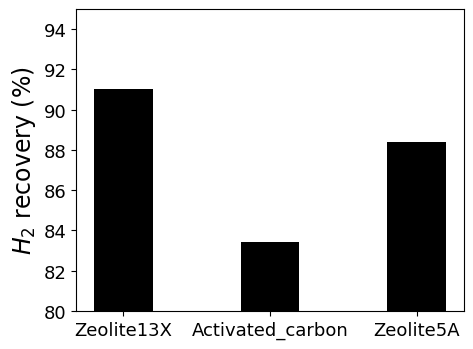

In [21]:
# Results plot
Adsorbent = ['Zeolite13X','Activated_carbon', 'Zeolite5A']
plt.figure(dpi=100, figsize=(5, 4))
plt.bar(Adsorbent, results, width=0.4, color='black')
plt.ylim([80, 95])
plt.ylabel('$H_2$ recovery (%)', fontsize=17)
plt.yticks(fontsize=13)
plt.xticks( fontsize=13)
plt.show()

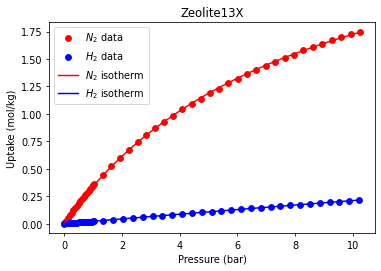

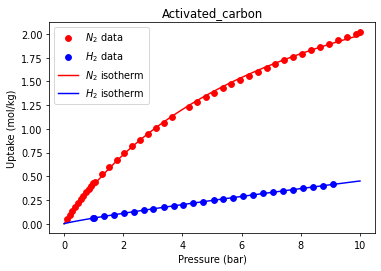

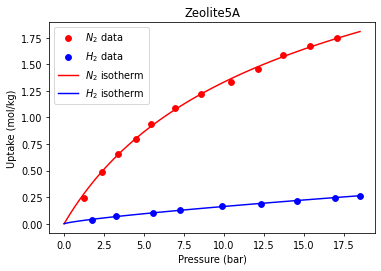

In [23]:
# Visualization ==> SI?
for i in range(3):
    ads = Data[i]
    
    P_N2 = ads['Pressure_N2 (bar)'].dropna().values
    q_N2 = ads['Uptake_N2 (mol/kg)'].dropna().values

    P_H2 = ads['Pressure_H2 (bar)'].dropna().values
    q_H2 = ads['Uptake_H2 (mol/kg)'].dropna().values
    
    plt.figure(dpi=70)
    plt.scatter(P_N2, q_N2, color = 'r')
    plt.scatter(P_H2, q_H2, color = 'b')
    
    P_max= max(max(P_N2), max(P_H2))
    P_dom = np.linspace(0, P_max, 100)
    plt.plot(P_dom, iso_pure[i][0](P_dom), color='r' )
    plt.plot(P_dom, iso_pure[i][1](P_dom), color='b' )
    
    plt.xlabel('Pressure (bar)')
    plt.ylabel('Uptake (mol/kg)')
    plt.title(f'{Adsorbent[i]}')
    plt.legend(['$N_2$ data', '$H_2$ data',
                '$N_2$ isotherm','$H_2$ isotherm'], loc='best')
    
    plt.show()

# Example 2

In [25]:
# pyAPEP package import
import pyadserver.isofit as isofit
import pyadserver.simsep as simsep

# Data treatment package import
import numpy as np
import pandas as pd

# Data visualization package import
import matplotlib.pyplot as plt

In [26]:
# Data import
Data = pd.read_csv('Example2_Zeolite13X.csv')

In [53]:
P_CO2 = Data['Pressure_CO2 (bar)'].dropna().values
q_CO2 = Data['Uptake_CO2 (mol/kg)'].dropna().values

P_CH4 = Data['Pressure_CH4 (bar)'].dropna().values
q_CH4 = Data['Uptake_CH4 (mol/kg)'].dropna().values

CO2_iso, _, _, _ = isofit.best_isomodel(P_CO2, q_CO2)
CH4_iso, _, _, _ = isofit.best_isomodel(P_CH4, q_CH4)
CO2_iso_ = lambda P,T: CO2_iso(P)
CH4_iso_ = lambda P,T: CH4_iso(P)

iso_mix = lambda P,T : isofit.IAST([CO2_iso_,CH4_iso_], P, T)

In [95]:
def mix_iso_arr(P_list, T_list):
    q_list = []
    for i in range(len(P_list[0])):
        P = [P_list[0][i]] + [P_list[1][i]]
        q = iso_mix(P, T_list[i])
        q_list.append(q)
    q_arr = np.array(q_list).T
    
    return q_arr

In [99]:
CR1 = simsep.column(1, 0.0314, 2 )

voidfrac = 0.4
rho = 1100
CR1.adsorbent_info(mix_iso_arr, voidfrac, rho_s = rho)   #rho_s : solid density

Mmol = [0.032, 0.044] # kg/mol
visc = [0.01, 0.01]  #Pa sec
CR1.gas_prop_info(Mmol, visc)

MTC = [0.05, 0.05]   #mass transfer coeff.
a_surf = 400 #Volumatric specific surface area (m2/m3)
CR1.mass_trans_info(MTC, a_surf)

dH_ads = [1000,1000]
Cp_s = 5
Cp_g = [10,10]
h_heat = 10
CR1.thermal_info(dH_ads, Cp_s, Cp_g, h_heat)

P_inlet = 9
P_outlet = 8.0
T_feed = 300
y_feed = [0.5,0.5]
CR1.boundaryC_info(P_outlet, P_inlet, T_feed, y_feed)

P_init = P_inlet*np.ones(11)
y_init = [0.2*np.ones(11), 0.8*np.ones(11)]
Tg_init = 300*np.ones(11)
Ts_init = 300*np.ones(11)

P_partial = [P_init*y_init[0], P_init*y_init[1]]
q_init = mix_iso_arr(P_partial, Ts_init)
# q_init = np.repeat(q, 11).reshape(2, -1)

CR1.initialC_info(P_init, Tg_init, Ts_init, y_init, q_init)
print(CR1)

y,z, t = CR1.run_mamoen(2000, n_sec=10, CPUtime_print=True)   #mamoen : mass, momentum, energy / n_sec : 1초를 몇개로 쪼갤래?

[[Current information included here]] 
Design          : True
adsorbent_info  : True
gas_prop_info   : True
mass_trans_info : True
thermal_info    : True
boundaryC_info  : True
initialC_info   : True
Flow direction  : Foward
Assigned velocity option: False

Simulation of this step is completed.
This took    64.492 mins to run. 



ValueError: too many values to unpack (expected 3)

In [100]:
y

NameError: name 'y' is not defined